# Part 6: Large-scale and distributed optimization

In [1]:
import importlib

import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset, unison_shuffled_copies, get_train_test_datasets, gradient_descent
from useful_functions import plot_convergence_rate, plot_evolution_on_test_error, plot_evolution_on_test_error_with_bias


### Question 1: Apply randomized block coordinate descent to your problem by considering a full batch of your dataset, and compare it with gradient descent. Is the use of coordinate descent beneficial on your problem?

In [2]:
#% of rows to include in training dataset
TRAINING_RATIO = 0.75
dataset = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)
A = dataset['data']
Y = dataset['target']
A_shuffled, Y_shuffled = unison_shuffled_copies(A, Y)
A_train, Y_train, A_test, Y_test = get_train_test_datasets(A_shuffled, Y_shuffled,TRAINING_RATIO)

In randomized block coordinate gradient descent, we will apply the gradient descent on full batch but instead of applying the transformation on all dimensions of the variable $x$ we will only apply it to some random block coordinates. 
The results for our problem is displayed below. As we can see the loss converges to a value similar to the one in GD, but the convergence is slower (as we don't apply the update to all coordinates) and is characterized by alternation of steep slopes and some plateau. The main reason for that is that each dimension of $x$ don't play the same role: same are important, some are not. As a result if we update some not so useful coordinates the change is small and we stay on the plateau, in the other case the change is huge and we decrease the loss a lot. 

For our problem however, we the use of coordinate descent doesn't seem to bring much added value and slows down the convergence.

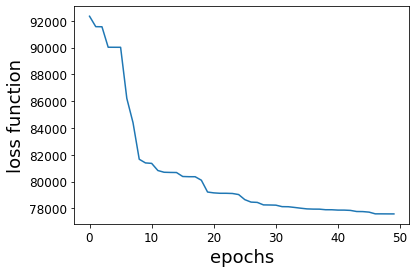

Optimal parameter is:
[ 0.72567387  0.30569015  0.30617323 -0.30070008  0.0724373  -0.05183392
  0.08454453  0.12463869]


In [5]:
# Coordinate GD implementation 
n_epochs = 50
step_size = 1e-5
n_sample = A_train.shape[0]
D = A_train.shape[1] # dimension of pbm 
Dblock = 1
x = np.random.rand(D) # random initialization

loss_function_train_coordinate = []
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_train_coordinate.append(loss_function_train)
    gradients = 2*A_train.T.dot(np.dot(A_train,x)-Y_train) #gradient of the smooth part 

    #coordinate 
    jk = np.random.choice(D,Dblock,replace=False) # Uniform draw without replacement
    x[jk] = x[jk] - step_size*gradients[jk]


plt.plot(epochs, loss_function_train_coordinate)   
plt.xlabel("epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()
print("Optimal parameter is:")
print(x)

### Question 2: Combine randomized block coordinate descent with stochastic gradient (i.e. the method from Part 3). Do you observe a benefit from using coordinates together with stochastic gradient?

When we combine SGD and Coordinate Descent, instead of using the full batch in CD we only use a single sample. Combining them leads to rather similar results as the classic GD in our case. However for problem with many features and a big dataset, such a technique would allows for paralellization (for various coordinates) and less calculation (only one sample).

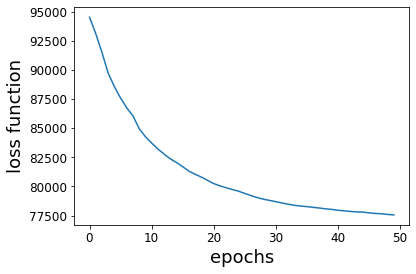

Optimal parameter is:
[ 0.84379913  0.34593435 -0.02755118  0.02326418  0.17756903 -0.04561557
  0.26794078  0.29768073]


In [7]:
# Coordinate SGD implementation 
n_epochs = 50
step_size = 1e-5
n_sample = A_train.shape[0]
D = A_train.shape[1] # dimension of pbm 
Dblock = 1
iter_per_epoch = A_train.shape[0]

x = np.random.rand(D) # random initialization

loss_function_array_sgd_coordinate = []
loss_function_array_sgd_coordinate_iteration = []
epochs = []
iteration = []


for epoch in range(n_epochs):
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_array_sgd_coordinate.append(loss_function_train)

    for i in range(iter_per_epoch):
        iteration.append(iter_per_epoch*epoch+i)
        loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
        loss_function_array_sgd_coordinate_iteration.append(loss_function_train)
        random_index = np.random.randint(iter_per_epoch)
        Ai = A_train[random_index:random_index+1]
        Yi = Y_train[random_index:random_index+1]
        gradients = 2*Ai.T.dot(Ai.dot(x) - Yi)

        #coordinate 
        jk = np.random.choice(D,Dblock,replace=False) # Uniform draw without replacement
        x[jk] = x[jk] - step_size*gradients[jk]


plt.plot(epochs, loss_function_array_sgd_coordinate)   
plt.xlabel("epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()
print("Optimal parameter is:")
print(x)